In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, 1)
        )
    
    def forward(self, x):
        attn_weights = self.attention(x)  # Shape: (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Shape: (batch_size, seq_len, 1)
        context = torch.sum(attn_weights * x, dim=1)  # Shape: (batch_size, input_dim)
        return context, attn_weights

In [3]:
class CNNWithAttention(nn.Module):
    def __init__(self, input_channels, output_size, conv_filters, kernel_size, attention_dim):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, conv_filters, kernel_size)
        self.relu = nn.ReLU()
        self.attention = Attention(conv_filters)
        self.fc = nn.Linear(conv_filters, output_size)
    
    def forward(self, x):
        # Input shape: (batch_size, input_channels, seq_len)
        x = self.conv1(x)  # Shape: (batch_size, conv_filters, seq_len)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # Shape: (batch_size, seq_len, conv_filters)
        context, attn_weights = self.attention(x)  # Shape: (batch_size, conv_filters)
        output = self.fc(context)  # Shape: (batch_size, output_size)
        return output, attn_weights

In [4]:
def generate_sine_wave(seq_len, num_samples):
    X = np.linspace(0, 4 * np.pi, seq_len * num_samples)
    y = np.sin(X)
    X = X.reshape(num_samples, seq_len)
    y = y.reshape(num_samples, seq_len)
    return X, y

seq_len = 50
num_samples = 1000
X, y = generate_sine_wave(seq_len, num_samples)

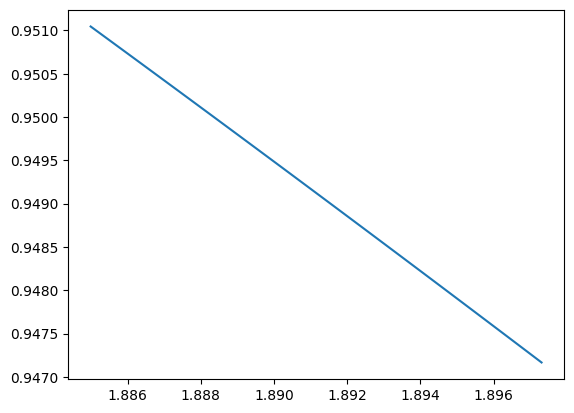

In [12]:
plt.plot(X[150], y[150])

In [13]:
# Prepare data for 1 time step ahead forecasting
train_X = np.array([y[i, :-1] for i in range(num_samples)]).reshape(num_samples, 1, seq_len-1)
train_y = np.array([y[i, 1:] for i in range(num_samples)]).reshape(num_samples, seq_len-1)

# Convert to PyTorch tensors
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y[:, :, None], dtype=torch.float32)  # Shape: (num_samples, seq_len-1, 1)

train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs, attn_weights = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Initialize model, loss function, and optimizer
input_channels = 1
output_size = 1
conv_filters = 64
kernel_size = 3
attention_dim = 64
num_epochs = 10

In [15]:
model = CNNWithAttention(input_channels, output_size, conv_filters, kernel_size, attention_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

/home/nipun.batra/miniconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 49, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (32) must match the size of tensor b (49) at non-singleton dimension 1